# Understanding Loan Approval Through the Payment Protection Program

Kira Loshin

## Introduction

In mid-2020, as the Coronavirus pandemic continued to have a global effect on the world economy, the United States created the [Payment Protection Program (PPP)](https://home.treasury.gov/policy-issues/coronavirus/assistance-for-small-businesses/paycheck-protection-program) to enable small businesses to continue to keep their workers on payroll. This program, which was run through the Small Business Association (SBA), allowed small businesses (< 500 employees) to apply for a low-interest private loan equal to about 10 weeks of pay. If the business continued to stay open and pay its employees, the loan was then forgiven by the government. The PPP had two rounds of loans: one in June 2020 and one in January 2021.

The loan amount was calculated as follows: $$L = \dfrac{yearly\_salary}{12} * 2.5$$ 


The way this funding worked was thaat first a small business would calculate their costs. For example, if a small business which comprised of a single employee made \\$100,000 a year, they would apply for a loan totalling \\$20,833. They would apply for this loan through their bank (known as the originating lender). If their loan forgiveness was approved, the SBA would then give give the small business's bank the reimbursement amount and the bank would then disburse that amount to the business. 

However, despite it being almost a year since the second round of loans has passed, many small business have not yet received their reimbursements. Can we find any reasons why some businesses may have received reimbursements while others have not? Can we attribute this to something specific to a small business or are there larger things at play with the originating lenders? When doing some initial data analysis on this dataset, there were some interesting things discovered about potential fraud both within the small businesses as well as the banks holding the reimbusement funds.

This analysis will look at individuals who applied for a PPP loan.

#### Importing Relevant Library Packages

In [96]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.error import HTTPError
import requests

import folium
from folium.plugins import TimestampedGeoJson
import pgeocode

import statsmodels.formula.api
import statsmodels.api as sm
import statistics as stats

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings

We will be using several Python packages to complete to complete this analysis. Some of the more important ones that will be used are [Pandas](https://pandas.pydata.org/), [Seaborn](https://seaborn.pydata.org/), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), [Folium](http://python-visualization.github.io/folium/), and [ScikitLearn](https://scikit-learn.org/stable/). Each webpage links to the library documentation for each package. These are each great resources to learn more about the libraries used here.
- Pandas and BeautifulSoup were both used to organize and work with the data.
- Seaborn and Folium were used for data visualization.
- ScikitLearn was used for machine learning.

In [15]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Data Collection

### Finding The Initial Dataset

Data from the PPP can be found [here](https://www.sba.gov/funding-programs/loans/covid-19-relief-options/paycheck-protection-program/ppp-data) on the SBA website. This dataset is comprised of several millions of rows. To make it more feasible for analysis, without loss of generality I decided to limit my analysis just to loans from small businesses in the state of Illinois. Illinos was selected for its relatively [high ranking for business](https://www.cnbc.com/2021/07/13/americas-top-states-for-business.html), [population size](https://worldpopulationreview.com/states), and [political lean](https://www.pewforum.org/religious-landscape-study/compare/party-affiliation/by/state/). This reduced the number of loans down to about 650,000, a more managable amount for this analysis.
<br>
The attributes for this dataset can understood as follows:
- LoanNumber: A unique number for each loan
- DateApproved: Date loan was funded
- SBAOfficeCode: SBA origination office code
- ProcessingMethod: Whether the loan was part of the first round or second round of loans
- BorrowerName: Name of borrower
- BorrowerAddress: Address of borrower
- BorrowerCity: City of borrower
- BorrowerState: State of borrower (all IL in this case)
- BorrowerZip: Zipcode of borrower
- LoanStatusDate: Date for loan status (blank when loan is disbursed byt not paid in full or charged off(
- LoanStatus: Status of loan (whether is has been disbursed, paid in full, charged off)
- Term: Term of loan
- SBAGuarantyPercentage: SBA Guaraty Percentgage
- InitialApprovalAmount: Original loan approval amount
- CurrentApprovalAmount: Current loan approval amount
- UndisbursedAmount: Undisbursed amount 
- FranchiseName: Name of franchise
- ServicingLenderLocationID: Unique identifier for servicing lender
- ServicingLenderName: Name of servicing lender
- ServicingLenderAddress: Address of servicing lender
- ServicingLenderCity: City of servicing lender
- ServicingLenderState: State of servicing lender
- ServicingLenderZip: Zipcode of servicing lender
- RuralUrbanIndicator: Rural or Urban business indicator
- HubzoneIndicator: Hubzone business indicator
- LMIIndicator: Low or moderate income indicator
- BusinessAgeDescription: Age of business
- ProjectCity: City of project
- ProjectCountyName: County of project
- ProjectState: State of project
- ProjectZip: Zipcode of project
- CD: Congressional district of project
- JobsReported: Number of jobs reported
- NAICSCode: North American Industry Classification System Code of business
- Race: Race of business owner
- Ethnicity: Ethnicity of business owner
- UTILITIES_PROCEED: Proceed data using for utilities
- PAYROLL_PROCEED: Proceed data using for payroll
- MORTGAGE_INTEREST_PROCEED: Proceed data using for morgage interest
- RENT_PROCEED: Proceed data using for rent
- REFINANCE_EIDL_PROCEED: Proceed data using for refinancing
- HEALTH_CARE_PROCEED: Proceed data using for healthcare
- DEBT_INTEREST_PROCEED: Proceed data using for debt interest
- BusinessType: Business type description
- OriginatingLenderLocationID: Unique identifier for originating lender
- OriginatingLender: Name of originating lender
- OriginatingLenderCity: City of originating lender
- OriginatingLenderState: State of originating lender
- Gender: Gender of business owner
- Veteran: Whether the business owner is a veteran
- NonProfit: Whether the business is a nonprofit
- ForgivenessAmount: Forgiveness amount
- ForgivenessDate: Forgiveness paid date

In [16]:
loans = pd.read_csv('il_loans.csv')

In [17]:
loans.head()

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,LoanStatus,Term,SBAGuarantyPercentage,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,FranchiseName,ServicingLenderLocationID,ServicingLenderName,ServicingLenderAddress,ServicingLenderCity,ServicingLenderState,ServicingLenderZip,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,ProjectCity,ProjectCountyName,ProjectState,ProjectZip,CD,JobsReported,NAICSCode,Race,Ethnicity,UTILITIES_PROCEED,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,REFINANCE_EIDL_PROCEED,HEALTH_CARE_PROCEED,DEBT_INTEREST_PROCEED,BusinessType,OriginatingLenderLocationID,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate
0,6499367101,4/14/2020,507,PPP,ENCORE SPACE SOLUTIONS INC.,120 Prairie Lake Rd,EAST DUNDEE,IL,60118-9103,NaN,Exemption 4,24,100,149999.00,149999.00,0.0,NaN,57328,The Huntington National Bank,17 S High St,COLUMBUS,OH,43215-3413,U,Y,Y,Existing or more than 2 years old,EAST DUNDEE,KANE,IL,60118-9103,IL-08,19,238350.0,White,Not Hispanic or Latino,NaN,149999.00,NaN,NaN,NaN,NaN,NaN,Corporation,57328,The Huntington National Bank,COLUMBUS,OH,Male Owned,Non-Veteran,NaN,151203.10,2/19/2021
1,7079868604,3/23/2021,507,PPS,235 ASHLAND HOLDINGS INC,235 N Ashland Ave,Chicago,IL,60607-1401,NaN,Exemption 4,60,100,149999.00,149999.00,0.0,NaN,58036,Fifth Third Bank,38 Fountain Sq Plz,CINCINNATI,OH,45263,U,Y,N,Existing or more than 2 years old,Chicago,COOK,IL,60607-1401,IL-07,19,722511.0,Unanswered,Unknown/NotStated,1.0,149993.00,NaN,NaN,NaN,NaN,NaN,Corporation,58036,Fifth Third Bank,CINCINNATI,OH,Unanswered,Unanswered,NaN,NaN,NaN
2,1327948901,4/24/2021,507,PPP,FRIDA KAHLO COMMUNITY ORGANIZATION,5133 S Kedzie Ave,Chicago,IL,60632-3126,NaN,Exemption 4,60,100,149997.00,149997.00,0.0,NaN,58036,Fifth Third Bank,38 Fountain Sq Plz,CINCINNATI,OH,45263,U,Y,Y,Existing or more than 2 years old,Chicago,COOK,IL,60632-3126,IL-04,22,611710.0,Unanswered,Unknown/NotStated,1.0,149991.00,NaN,NaN,NaN,NaN,NaN,Subchapter S Corporation,58036,Fifth Third Bank,CINCINNATI,OH,Unanswered,Unanswered,NaN,NaN,NaN
3,5688247203,4/27/2020,507,PPP,ONTARIO AND CASS LLC,247 E ONTARIO ST 2ND FLOOR CHICAGO IL 60611,CHICAGO,IL,60611,5/21/2021,Paid in Full,24,100,149995.00,149995.00,0.0,NaN,21059,Republic Bank of Chicago,2221 Camden Court,OAK BROOK,IL,60523-1273,U,N,N,Existing or more than 2 years old,CHICAGO,COOK,IL,60611-0001,IL-07,15,722511.0,Asian,Not Hispanic or Latino,NaN,149995.00,NaN,NaN,NaN,NaN,NaN,Limited Liability Partnership,21059,Republic Bank of Chicago,OAK BROOK,IL,Male Owned,Non-Veteran,NaN,151444.95,4/19/2021
4,2037218302,1/20/2021,507,PPS,MSI GREEN INC.,1958 W Grand Ave,Chicago,IL,60622-6232,NaN,Exemption 4,60,100,149994.38,149994.38,0.0,NaN,21023,Byline Bank,"180 N LaSalle St, Ste 300",CHICAGO,IL,60601-3110,U,N,N,Existing or more than 2 years old,Chicago,COOK,IL,60622-6232,IL-05,12,424410.0,Unanswered,Not Hispanic or Latino,1.0,149989.38,NaN,NaN,NaN,NaN,NaN,Corporation,21023,Byline Bank,CHICAGO,IL,Female Owned,Non-Veteran,NaN,NaN,NaN


### Web Scraping Average Salaries

The loan amount request was calculated by determing the 10 week salary amount for the business. These values can be verified by comparing the salaries for each loan's profession to the published mean salaries. This data is published by the US Bureau of Labor Statistics and can be found [here](https://www.bls.gov/oes/current/oes_nat.htm). 

In [18]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"}
try:
    res = requests.get("https://www.bls.gov/oes/current/oes_nat.htm", headers=headers)
except HTTPError as e:
    print(e)

In [19]:
bs = BeautifulSoup(res.text, 'html.parser')
tab = bs.findAll("table")
df = pd.read_html(str(tab[1]))
merged = df[0]
merged = merged[1:] # Remove the first row, since it is only NaN
merged.head()

,Occupation code,Occupation title (click on the occupation title to view its profile),Level,Employment,Employment RSE,"Employment per 1,000 jobs",Median hourly wage,Mean hourly wage,Annual mean wage,Mean wage RSE
1,00-0000,All Occupations,total,139099570,0.1%,1000.000,$20.17,$27.07,"$56,310",0.1%
2,11-0000,Management Occupations,major,7947300,0.2%,57.134,$52.77,$60.81,"$126,480",0.2%
3,11-1000,Top Executives,minor,2601070,0.4%,18.699,$51.05,$62.46,"$129,920",0.2%
4,11-1011,Chief Executives,detail,202360,1.0%,1.455,$89.40,$95.12,"$197,840",0.5%
5,11-1021,General and Operations Managers,detail,2347420,0.4%,16.876,$49.83,$60.45,"$125,740",0.2%


### Getting NAICS Codes

In order to compare occupations in the PPP data to occupations in the salary data, a mapping must be done between the two datasets. This can be done by using the NAICSCodes column in the PPP dataset and the Occupation Title column in the salaries dataset. To get a mapping for them, I took an excel mapping found on the Census Bureau website [here](https://www.census.gov/naics/). These will later be cleaned and translated for use.

In [20]:
code = pd.read_excel('6-digit_2017_Codes.xlsx')

In [21]:
code.head()

,2017 NAICS Code,2017 NAICS Title,Unnamed: 2
0,NaN,NaN,NaN
1,111110.0,Soybean Farming,NaN
2,111120.0,Oilseed (except Soybean) Farming,NaN
3,111130.0,Dry Pea and Bean Farming,NaN
4,111140.0,Wheat Farming,NaN


## Data Processing

Now, let's begin our data processing by cleaning up the datasets. Each dataset will need to be separately modified before it can be pieced together into a complete dataset. There are a few general things that will be done during data cleaning and data processing. Each dataset will have extraneous (non-relavent) columns deleted. This will make processing the data happen much more quickly for later analysis. We'll also transform any columns with dates into datetime columns, casting data (when appropriate), and split strings as needed.

### Cleaning the PPP Dataset

To clean the PPP dataset, we want to drop columns we won't need for analysis. The primary columns we will be looking at are: BorrowerZip, InitialLoanAmount, NAICSCode

#### Dropping unnecessary columns

In [22]:
loans.drop(columns=['LoanNumber', 'SBAOfficeCode', 'ProcessingMethod', 'BorrowerName', 'BorrowerAddress', 'BorrowerCity', 'BorrowerState', 'Term', 'SBAGuarantyPercentage', 'FranchiseName', 'ServicingLenderLocationID', 'ServicingLenderAddress', 'ServicingLenderCity', 'ServicingLenderState', 'ServicingLenderZip', 'ProjectCity', 'ProjectCountyName', 'ProjectState', 'ProjectZip', 'CD', 'UTILITIES_PROCEED', 'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED', 'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED', 'DEBT_INTEREST_PROCEED', 'OriginatingLenderLocationID', 'OriginatingLenderCity', 'OriginatingLenderState'], inplace=True)

#### Adding datetime Columns

In [23]:
dates = pd.to_datetime(loans["DateApproved"])
loans = loans.drop(columns=["DateApproved"])
loans["DateApproved"] = dates

dates = pd.to_datetime(loans["ForgivenessDate"])
loans = loans.drop(columns=["ForgivenessDate"])
loans["ForgivenessDate"] = dates

dates = pd.to_datetime(loans["LoanStatusDate"])
loans = loans.drop(columns=["LoanStatusDate"])
loans["LoanStatusDate"] = dates

#### Limiting results to individuals applying for the loan

For the purpose of our analysis, we will only be looking at loans where the 'JobsReported' was 1. This is to specifically look out for individuals who may be taking advantage of the PPP loan or who may have been taken advantage of. It also will provide us with a direct metric for measuring proposed salaries against the reported average salaries.

In [24]:
single = loans[loans['JobsReported'] == 1]

#### Cleaning zip codes

Later on in our analysis, we will be mapping zip codes. The package we will be using to complete this analysis assumes each zip code is five digits. We transform the data here to meet that requirement.

In [25]:
single['Zipcode'] = single['BorrowerZip'].str[:5]
single.drop(columns=['BorrowerZip'], inplace=True)

### Cleaning the Salary Dataset

The only relevant information for this dataset is the mean salary for each occupation. Here we will drop the unnecessary columns, create our salary column by removing unnecessary strings, and rename our columns to better reflect the data each column contains.

#### Getting the salary information

In [26]:
merged["Annual mean wage"] = merged["Annual mean wage"].replace('[\$,]', '', regex=True)
merged["Annual mean wage"] = merged["Annual mean wage"].replace('(4)', np.nan)
merged["Annual mean wage"] = merged["Annual mean wage"].astype(float)

#### Dropping unnecessary columns

In [27]:
merged.drop(columns=['Level','Employment', 'Employment RSE', 'Employment per 1,000 jobs', 'Median hourly wage', 'Mean hourly wage', 'Mean wage RSE'], inplace=True)

#### Renaming columns

In [28]:
avg_sals = merged.rename(columns={"Occupation title (click on the occupation title to view its profile)": "Title", "Annual mean wage": "Salary"})

### Cleaning the NAICS dataset

The NAICS dataset contains the mapping between occupations and NAICS codes. There are some formatting issues that need to be adjusted by shifting the data and the columns need to be renamed to better match the columns from the other datasets. This will make merging the datasets more straightforward once we merge them in a little bit.

In [29]:
code = code[1:] # Remove the first row, since it is only NaN
code = code.iloc[: , :-1] # drop last column
code['2017 NAICS Code'] = code['2017 NAICS Code'].astype(int)
code = code.rename(columns={"2017 NAICS Code": "NAICSCode", "2017 NAICS Title":"Title"})

### Merging the Datasets

Now that our datasets are clean, let's merge them together. Merging the single loans dataset and the NAICS code dataset provides us with a reference to the salary dataset that we will utilize later.

In [30]:
vals = pd.merge(single, code, on="NAICSCode")

In [31]:
vals.head()

,LoanStatus,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,ServicingLenderName,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,JobsReported,NAICSCode,Race,Ethnicity,BusinessType,OriginatingLender,Gender,Veteran,NonProfit,ForgivenessAmount,DateApproved,ForgivenessDate,LoanStatusDate,Zipcode,Title
0,Paid in Full,149362.0,149362.00,0.0,"T Bank, National Association",U,N,N,Existing or more than 2 years old,1,621210.0,Unanswered,Unknown/NotStated,Sole Proprietorship,"T Bank, National Association",Male Owned,Unanswered,NaN,150491.42,2020-05-08,2021-02-19,2021-03-13,61114,Offices of Dentists
1,Exemption 4,147322.5,147322.50,0.0,First Midwest Bank,U,N,N,Existing or more than 2 years old,1,621210.0,Unanswered,Unknown/NotStated,Limited Liability Company(LLC),First Midwest Bank,Unanswered,Unanswered,NaN,148697.51,2020-04-10,2021-03-26,NaT,60515,Offices of Dentists
2,Paid in Full,145677.5,145677.50,0.0,First Midwest Bank,U,N,N,Existing or more than 2 years old,1,621210.0,White,Not Hispanic or Latino,Subchapter S Corporation,First Midwest Bank,Female Owned,Veteran,NaN,146838.87,2020-04-11,2021-02-02,2021-04-23,60056,Offices of Dentists
3,Paid in Full,141875.0,130541.27,0.0,First American Bank,U,N,N,Existing or more than 2 years old,1,621210.0,Unanswered,Unknown/NotStated,Limited Liability Company(LLC),First American Bank,Male Owned,Non-Veteran,NaN,131766.91,2020-04-28,2021-04-15,2021-05-21,60045,Offices of Dentists
4,Paid in Full,109375.0,109375.00,0.0,First Midwest Bank,U,N,N,New Business or 2 years or less,1,621210.0,Unanswered,Unknown/NotStated,Limited Liability Company(LLC),First Midwest Bank,Unanswered,Non-Veteran,NaN,110611.55,2020-04-11,2021-06-03,2021-06-24,60540,Offices of Dentists


## Exploratory Data Analysis

Now that we have our clean dataset, it's time to move on to the next part of the data science pipeline: Exploratory Data Analysis. Using our dataset, we'll try and use some data visualization techniques to discover trends in the data. Some questions we'd like to answer are:
- Are there still many loans that are undisbursed?
- Can we find any factors that may be related to undisbursed loans?
- How to the proposed salaries (listed in the loan application) match up with the average salary for each job? Are there any jobs where that discrepancy is large?

Once we answer some of these initial questions, we can try and pull out specific factors which may have an effect on the things we are checking. Later on, we will test whether these factors have an actual effect on the data (or whether they are simply a conincidence).

### Counting undisbursed loans

In [32]:
vals[vals['UndisbursedAmount'] > 0].count()

LoanStatus                41968
InitialApprovalAmount     41968
CurrentApprovalAmount     41968
UndisbursedAmount         41968
ServicingLenderName       41968
RuralUrbanIndicator       41968
HubzoneIndicator          41968
LMIIndicator              41968
BusinessAgeDescription    41968
JobsReported              41968
NAICSCode                 41968
Race                      41968
Ethnicity                 41968
BusinessType              41968
OriginatingLender         41968
Gender                    41968
Veteran                   41968
NonProfit                    18
ForgivenessAmount            13
DateApproved              41968
ForgivenessDate              13
LoanStatusDate            41933
Zipcode                   41968
Title                     41968
dtype: int64

From here we can see that nearly 42,000 of the loans are still undisbursed! Let's try and take a closer look at what's going on here.

### Exploring undisbursed loans

First, let's look at how many loans are not yet disbursed. We'll filter our data to only reflect loans which have not been disbursed. Remember that undisbursed loans mean that the government has paid the lender the loan amount-- the lender just hasn't given that money back to the borrower. Since the money is currently with the lender, let's first see if there is anything we can learn about the lenders themselves.

In [36]:
# Add a new column, percent undisbursed, which is a fraction of how much of a loan is still undisbursed
vals['PctUndisbursed'] = vals['UndisbursedAmount'] / vals['InitialApprovalAmount']

In [34]:
# Only keep rows where there is still undisbursed funds
vals_undisbursed = vals.drop(vals[vals['UndisbursedAmount'] == 0].index)

#### Looking at originating lenders

Text(0.5, 1.0, 'Undisbursed Loans: Originating Lender')

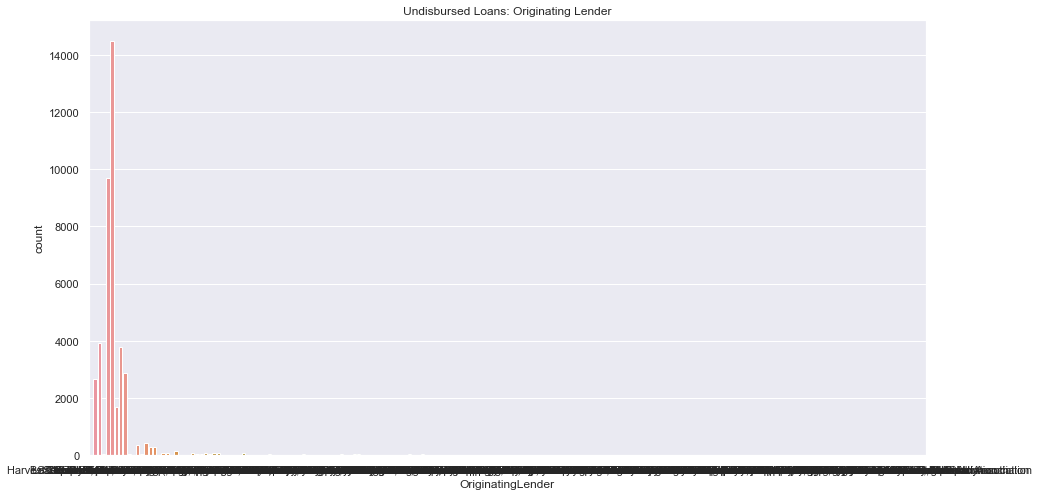

In [39]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="OriginatingLender",data=vals_undisbursed).set_title("Undisbursed Loans: Originating Lender")

Looking at this count, there appears to be quite a few outliers! Let's see if we can get a closer look at which lenders these are. We'll do this by filtering our dataset to only show us lenders who have > 1000 undisbursed loans.

In [37]:
lender_undispersed = vals_undisbursed[vals_undisbursed.groupby('OriginatingLender').OriginatingLender.transform('count')>1000].copy() 

Text(0.5, 1.0, 'Undisbursed Loans: Originating Lender, top offenders')

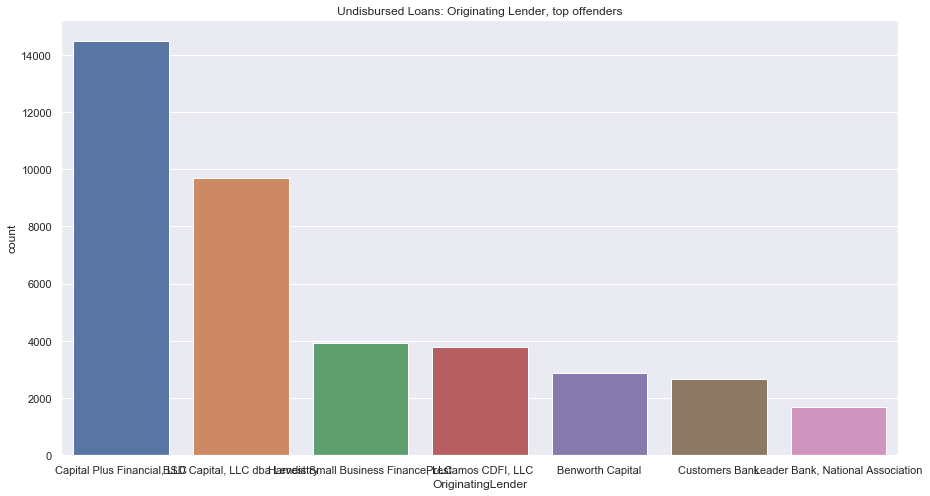

In [40]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="OriginatingLender",data=lender_undispersed, order = lender_undispersed['OriginatingLender'].value_counts().index).set_title("Undisbursed Loans: Originating Lender, top offenders")

We can clearly see seven lenders which are holding onto undisbursed funds. They are: Capital Plus Financial, LLC, BSD Capital, LLC, Harvest Small Business Financial, LLC, Prestamos CDFI, LLC, Benworth Capital, Customers Bank, and Leader Bank, National Association. We'll hang onto these lenders and take a closer look at them later on in the tutorial.

#### Looking at NAICS Codes

Next, let's see if there are any trends between the type of job an individual has and whether that has any effect on whether the loan remains undisbursed. We will once again plot the count and filter based on outliers.

Text(0.5, 1.0, 'Undisbursed Loans: NAICS Codes')

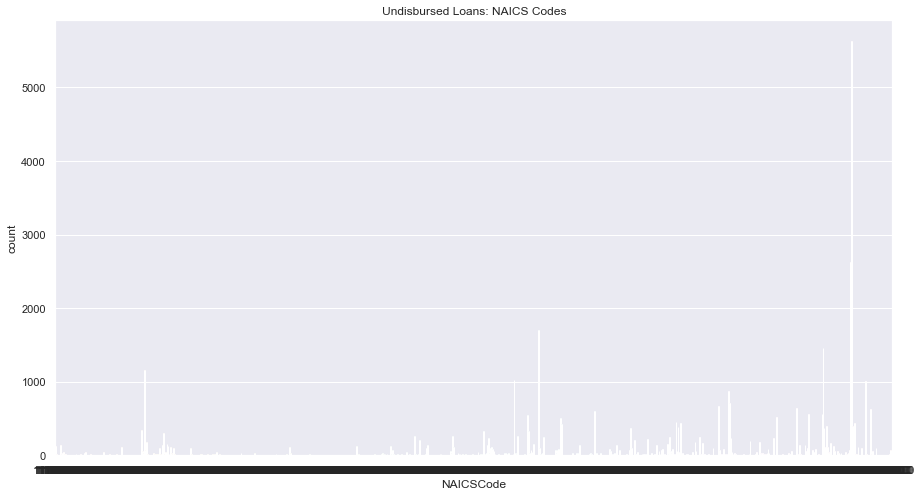

In [60]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="NAICSCode",data=vals_undisbursed).set_title("Undisbursed Loans: NAICS Codes")

In [41]:
vals_sort = vals_undisbursed[vals_undisbursed.groupby('NAICSCode').NAICSCode.transform('count')>500].copy() 

Text(0.5, 1.0, 'Undisbursed Loans: NAICS Codes, top codes')

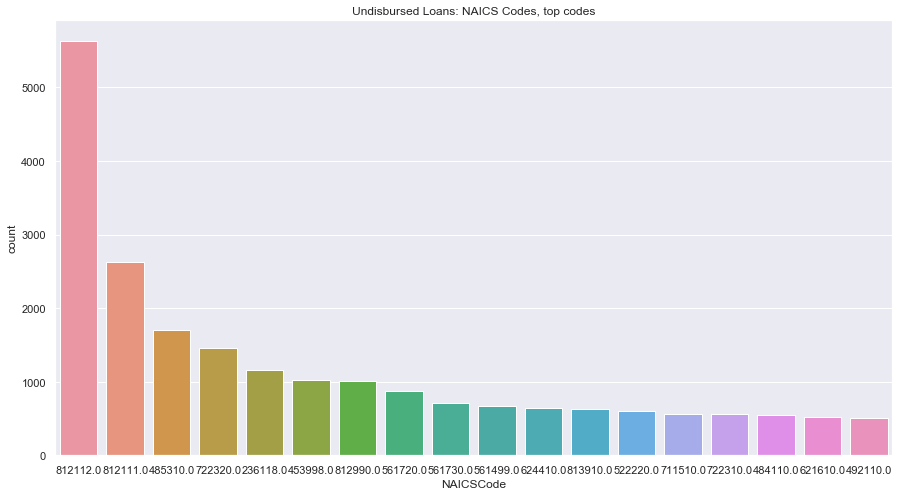

In [42]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="NAICSCode",data=vals_sort, order = vals_sort['NAICSCode'].value_counts().index).set_title("Undisbursed Loans: NAICS Codes, top codes")

Text(0.5, 1.0, 'Violin Plot ofUndisbursed Loans: NAICS Codes, top codes')

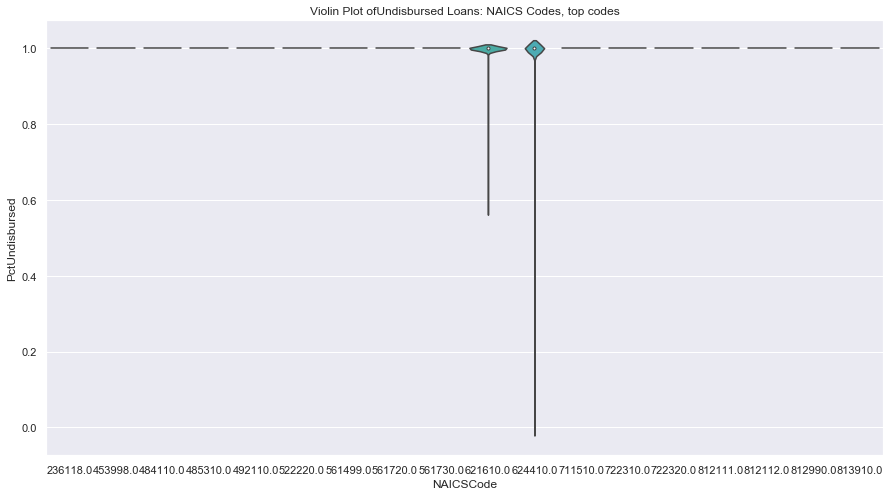

In [57]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.violinplot(x="NAICSCode", y="PctUndisbursed", data=vals_sort).set_title("Violin Plot of Undisbursed Loans: NAICS Codes, top codes")

There once again seems to be several outliers here. Looking at a violin plot of the data, we can see that there is no real variation for each of these loans: each one seems to be completely undisbursed. Despite there seeming to be a little bit of variation for a couple of the codes, the white dot in the center of each of those plots at 1.0 (and the relative flatness of each plot) indicates that these loans can be considered completely undisbursed as well. Let's take a closer look at these NAICS codes. What are these jobs? Is there something unusual here that may be preventing the loan from getting disbursed?
<br>
<br>
We'll begin this analysis by matching these jobs with the corresponding salary information from the salary dataset. Since there is no direct connection between the NAICS codes and salary occupation code, we'll manually match each of these salaries to the closest matching value.

In [43]:
order = vals_sort['Title'].value_counts().index
vals_comp = vals_sort.copy()

In [45]:
# Let's look at what these outlier salaries are:
print(order)

Index(['Beauty Salons ', 'Barber Shops ', 'Taxi Service ', 'Caterers',
       'Residential Remodelers ',
       'All Other Miscellaneous Store Retailers (except Tobacco Stores) ',
       'All Other Personal Services ', 'Janitorial Services ',
       'Landscaping Services', 'All Other Business Support Services ',
       'Child Day Care Services ', 'Business Associations ',
       'Sales Financing ', 'Independent Artists, Writers, and Performers ',
       'Food Service Contractors', 'General Freight Trucking, Local ',
       'Home Health Care Services', 'Couriers and Express Delivery Services'],
      dtype='object')


In [48]:
# Matching each of these salaries to a corresponding value
a = avg_sals.loc[avg_sals['Title'] == 'Barbers, Hairdressers, Hairstylists and Cosmetologists']
b = avg_sals.loc[avg_sals['Title'] == 'Barbers']
c = avg_sals.loc[avg_sals['Title'] == 'Passenger Vehicle Drivers, Except Bus Drivers, Transit and Intercity']
d = avg_sals.loc[avg_sals['Title'] == 'Food Service Managers']
e = avg_sals.loc[avg_sals['Title'] == 'Construction Laborers']
f = avg_sals.loc[avg_sals['Title'] == 'Retail Sales Workers']
g = avg_sals.loc[avg_sals['Title'] == 'Personal Care and Service Occupations']
h = avg_sals.loc[avg_sals['Title'] == 'Janitors and Cleaners, Except Maids and Housekeeping Cleaners']
i = avg_sals.loc[avg_sals['Title'] == 'Landscaping and Groundskeeping Workers']
j = avg_sals.loc[avg_sals['Title'] == 'Office and Administrative Support Workers, All Other']
k = avg_sals.loc[avg_sals['Title'] == 'Childcare Workers']
l = avg_sals.loc[avg_sals['Title'] == 'Business Operations Specialists']
m = avg_sals.loc[avg_sals['Title'] == 'Securities, Commodities, and Financial Services Sales Agents']
n = avg_sals.loc[avg_sals['Title'] == 'Artists and Related Workers, All Other']
o = avg_sals.loc[avg_sals['Title'] == 'Food Preparation Workers']
p = avg_sals.loc[avg_sals['Title'] == 'Heavy and Tractor-Trailer Truck Drivers']
q = avg_sals.loc[avg_sals['Title'] == 'Home Health and Personal Care Aides']
r = avg_sals.loc[avg_sals['Title'] == 'Driver/Sales Workers and Truck Drivers']

rows = [a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r]

t = pd.concat(rows)

toComp = ['Beauty Salons ', 'Barber Shops ', 'Taxi Service ', 'Caterers',
       'Residential Remodelers ',
       'All Other Miscellaneous Store Retailers (except Tobacco Stores) ',
       'All Other Personal Services ', 'Janitorial Services ',
       'Landscaping Services', 'All Other Business Support Services ',
       'Child Day Care Services ', 'Business Associations ',
       'Sales Financing ', 'Independent Artists, Writers, and Performers ',
       'Food Service Contractors', 'General Freight Trucking, Local ',
       'Home Health Care Services', 'Couriers and Express Delivery Services']

# Matching the column information
t['titleToComp'] = toComp

Now we'll merge our new dataset. We'll do this on our initial dataset (with both disbursed and undisbursed values) to see how these jobs compare to the larger dataset. We'll also introduce two new variables:
- RemainingUndisbursed: This is a boolean column indicating whether there remains undisbursed funds for the given business
- SalaryExp: Since each business was only allowed to request up to 10 weeks worth of pay, using the equation from the beginning of this notebook we have determined what the expected yearly salary should be given the initial approval amount

In [53]:
sal_to_comp = pd.merge(vals, t,  left_on='Title', right_on='titleToComp')

sal_to_comp.head(5)

,LoanStatus,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,ServicingLenderName,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,JobsReported,NAICSCode,Race,Ethnicity,BusinessType,OriginatingLender,Gender,Veteran,NonProfit,ForgivenessAmount,DateApproved,ForgivenessDate,LoanStatusDate,Zipcode,Title_x,PctUndisbursed,Occupation code,Title_y,Salary,titleToComp
0,Paid in Full,137169.0,137169.0,0.0,"U.S. Bank, National Association",U,N,N,Existing or more than 2 years old,1,236118.0,White,Not Hispanic or Latino,Corporation,"U.S. Bank, National Association",Male Owned,Veteran,NaN,138460.67,2020-05-01,2021-04-12,2021-05-22,60643,Residential Remodelers,0.0,47-2061,Construction Laborers,43000.0,Residential Remodelers
1,Exemption 4,53607.5,53607.5,0.0,Citizens Bank of Chatsworth,U,N,Y,Existing or more than 2 years old,1,236118.0,Unanswered,Unknown/NotStated,Sole Proprietorship,Citizens Bank of Chatsworth,Unanswered,Unanswered,NaN,NaN,2021-04-21,NaT,NaT,61701,Residential Remodelers,0.0,47-2061,Construction Laborers,43000.0,Residential Remodelers
2,Active Un-Disbursed,52380.0,52380.0,52380.0,"Leader Bank, National Association",U,N,Y,Existing or more than 2 years old,1,236118.0,Unanswered,Unknown/NotStated,Corporation,"Leader Bank, National Association",Unanswered,Unanswered,NaN,NaN,2021-05-12,NaT,2021-05-12,60438,Residential Remodelers,1.0,47-2061,Construction Laborers,43000.0,Residential Remodelers
3,Active Un-Disbursed,50000.0,50000.0,50000.0,Texas National Bank,U,N,N,Existing or more than 2 years old,1,236118.0,Unanswered,Unknown/NotStated,Self-Employed Individuals,Texas National Bank,Unanswered,Unanswered,NaN,NaN,2021-05-20,NaT,2021-05-20,60490,Residential Remodelers,1.0,47-2061,Construction Laborers,43000.0,Residential Remodelers
4,Exemption 4,38460.0,38460.0,0.0,"U.S. Bank, National Association",U,Y,N,Existing or more than 2 years old,1,236118.0,Black or African American,Not Hispanic or Latino,Subchapter S Corporation,"U.S. Bank, National Association",Male Owned,Unanswered,NaN,NaN,2021-03-26,NaT,NaT,60609,Residential Remodelers,0.0,47-2061,Construction Laborers,43000.0,Residential Remodelers


In [54]:
sal_to_comp['RemainingUndisbursed'] = False
sal_to_comp.loc[sal_to_comp['UndisbursedAmount'] != 0, 'RemainingUndisbursed'] = True

sal_to_comp['SalaryExp'] = 12 * (sal_to_comp['InitialApprovalAmount']/2.5)

Let's pull out the top 6 NAICS codes to get a closer look. We'll graph each of these plots by adding an axis line for the average salary of each profession and a hue to determine if there are remaining undisbursed funds.

In [61]:
salons = sal_to_comp.loc[sal_to_comp['NAICSCode'] == 812112]
barbers = sal_to_comp.loc[sal_to_comp['NAICSCode'] == 812111]
drivers = sal_to_comp.loc[sal_to_comp['NAICSCode'] == 485310]
caterers = sal_to_comp.loc[sal_to_comp['NAICSCode'] == 722320]
remodelers = sal_to_comp.loc[sal_to_comp['NAICSCode'] == 236118]
retailers = sal_to_comp.loc[sal_to_comp['NAICSCode'] == 453998]

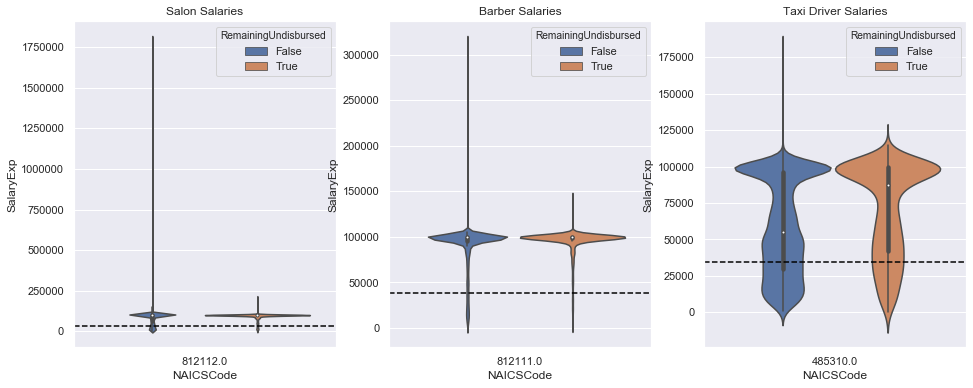

In [85]:
_ , ax = plt.subplots(1,3, figsize=(16,6))
sns.violinplot(x="NAICSCode", y = 'SalaryExp', data = salons, hue='RemainingUndisbursed', ax = ax[0]).set_title("Salon Salaries")
l0=ax[0].axhline(32990,color='black',ls='--')
sns.violinplot(x="NAICSCode", y = 'SalaryExp', data = barbers, hue='RemainingUndisbursed', ax = ax[1]).set_title("Barber Salaries")
l1=ax[1].axhline(38050,color='black',ls='--')
sns.violinplot(x="NAICSCode", y = 'SalaryExp', data = drivers, hue='RemainingUndisbursed', ax = ax[2]).set_title("Taxi Driver Salaries")
l2=ax[2].axhline(34360,color='black',ls='--')

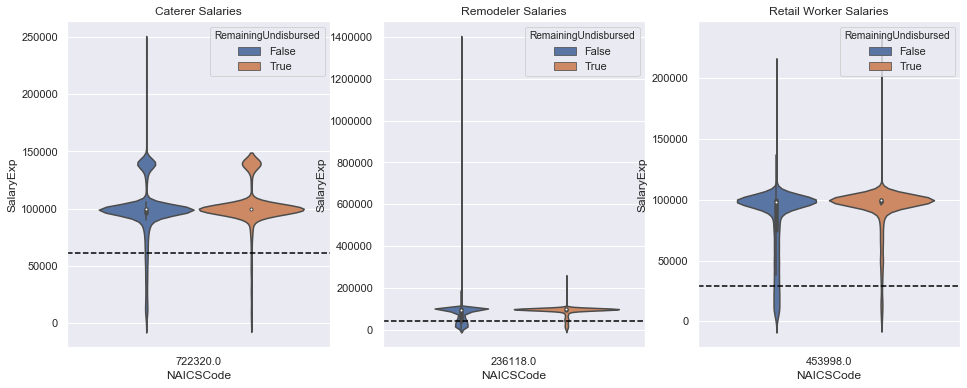

In [87]:
_ , ax = plt.subplots(1,3, figsize=(16,6))
sns.violinplot(x="NAICSCode", y = 'SalaryExp', data = caterers, hue='RemainingUndisbursed', ax = ax[0]).set_title("Caterer Salaries")
l0=ax[0].axhline(61000,color='black',ls='--')
sns.violinplot(x="NAICSCode", y = 'SalaryExp', data = remodelers, hue='RemainingUndisbursed', ax = ax[1]).set_title("Remodeler Salaries")
l1=ax[1].axhline(43000,color='black',ls='--')
sns.violinplot(x="NAICSCode", y = 'SalaryExp', data = retailers, hue='RemainingUndisbursed', ax = ax[2]).set_title("Retail Worker Salaries")
l2=ax[2].axhline(29010,color='black',ls='--')

It's interesting to note here that while there does not seem to be any correlation between the amout request and whether the funds were disbursed, the salary expectations for each of these jobs are significantly higher than what the average should be. For example, barber shops and retail workers consistently are claiming that their salaries are almost double average (about \\$100,000). In several of these cases, there are individuals requesting the equivalent of several hundred thousand dollars (an entire order of magnitude above average). One other interesting point is that the average salary request for undisbursed funds for taxi drivers is almost twice that of taxi drivers whose funds were disbursed. We will continue our analysis keeping these ideas in mind.

#### Looking at Demographic Data

We'll now look at a few different demographic metrics for our previously determined NAICS codes. These plots should help us determine whether these attributes can later be used for predictive analysis.

Text(0.5, 1.0, 'Undisbursed Funds: Gender')

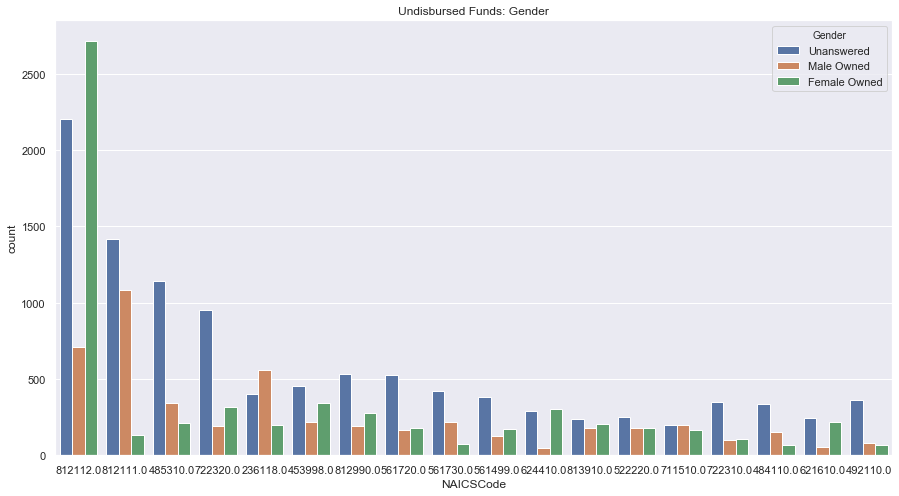

In [88]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="NAICSCode",data=vals_sort, order = vals_sort['NAICSCode'].value_counts().index, hue='Gender').set_title("Undisbursed Funds: Gender")

Text(0.5, 1.0, 'Undisbursed Funds: Veteran Status')

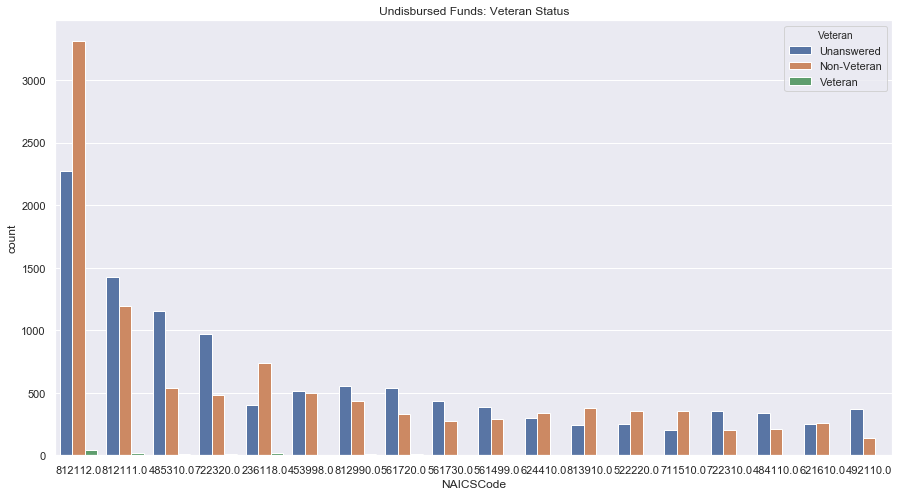

In [89]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="NAICSCode",data=vals_sort, order = vals_sort['NAICSCode'].value_counts().index, hue='Veteran').set_title("Undisbursed Funds: Veteran Status")

Text(0.5, 1.0, 'Undisbursed Funds: Race')

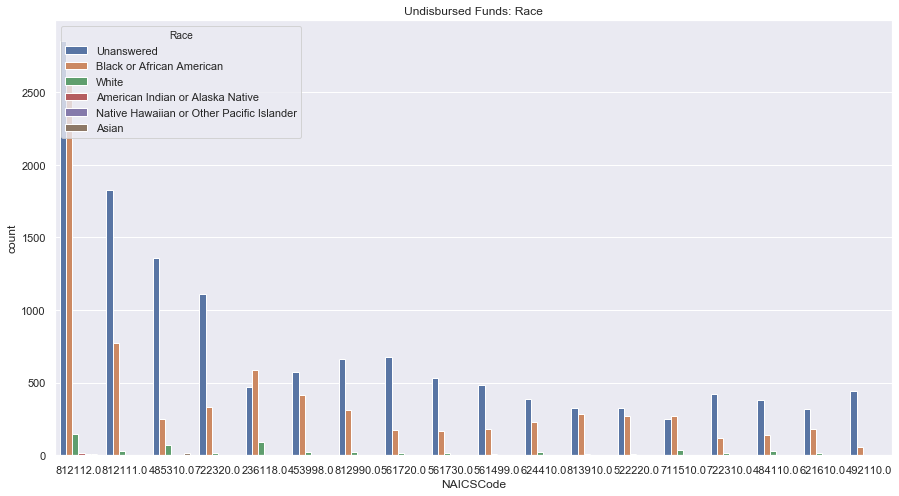

In [90]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="NAICSCode",data=vals_sort, order = vals_sort['NAICSCode'].value_counts().index, hue='Race').set_title("Undisbursed Funds: Race")

Looking at this demographic data, we can see that the majority of borrowers did not answer questions related to gender, race, and veteran status. These are all cases of Missing Not At Random data. There are a few different ways for resolving this. One method is to impute the data and test how it effects our datasets. Another method would be to look at the census data for each borrower's zip code and fill in the best approximation of each borrower's demographics. In our case, we will drop these attributes when completing our predictive analysis- since it was majority unanswered, these demographics were presumably not relevant when approving the loans.

#### Looking at location data

The last attribute we will analyze in our exploratory data analysis phase is location data. We will see if there is anything we can discern based on address information for each borrower. To do this, we need to get the latitude and longitude of each address. This process can take an extremely long time complete, so instead of running the address code more than once, we have instead run it in a separate window and exported the addresses into a csv that can be loaded in. The code to build this csv is provided, but commented out.
<br>
<br>
This map was built using Folium (referenced above). Each dot on the map represents the amount of the loan that is still undisbursed.

In [ ]:
'''
coords = []
for addr, city, state in zip(single['BorrowerAddress'], single['BorrowerCity'], single['BorrowerState']):
    loc = geolocator.geocode(addr+ ',' +city+','+ state, timeout=None)
    
    if (loc is None):
        loc = geolocator.geocode(city+','+ state, timeout=None)
    elif(loc.latitude is None or loc.longitude is None):
        coords.append([100,100])
    else:
        coords.append([loc.latitude, loc.longitude])
'''

In [ ]:
# setting the starting latitude, longitude and zoom.
loans_map = folium.Map(location=[40.1469622455993, -88.97747884394317], zoom_start=4.45, tiles='Stamen Terrain')

# this funciton returns a color based on the value of damage property
def rank_amount(amount):
    if amount == 0:
        return 'lightgreen'
    elif amount > 0 and amount < 0.25:
        return 'green'
    elif amount > 0.25 and amount < 0.5:
        return 'yellow'
    elif amount > 0.5 and amount < 0.75:
        return 'orange'
    elif amount > 0.75:
        return 'red'
    else:
        return 'black'

In [ ]:
for coords, amount in zip(coords_to_test['coords'], coords_to_test['PctUndisbursed']):
    folium.CircleMarker(
        location = coords, 
        radius=2, 
        fill=True, 
        color=rank_amount(amount)).add_to(loans_map)

In [ ]:
loans_map

## Analysis: Hypothesis Testing and Machine Learning

Now that we've completed our Exploratory Data Analysis, we can now dive into our hypothesis testing and machine learning algorithms. The two main attributes we'd like to look at for our testing is OriginatingLender and NAICSCode, since both of these attributes seemed to have some significant outliers when visualizing the data. We'll start off by running logistic regression on our outlier lenders and outlier NAICS codes to check whether there is a correlation between these values and whether a borrower still has an undisbursed balance.

### Hypothesis Testing

First, let's see if it is true that there is a relationship between the originating lender a business chooses to use and whether they still have undisbursed funds. Since these are categorical variables, we will conduct a logistic regression analysis using the 'OriginatingLender' and 'RemainingUndisbursed' columns. Since we will be using logistic regression, we used one-hot encoding to check if the originating lender was any of our previously determined outlier lenders.

The results of this analysis will help us see if there is truly a relationship between these values.

In [91]:
analysis = vals.copy()

#### Analysis on Originating Lender Information

In [92]:
analysis['RemainingUndisbursed'] = 0
analysis.loc[vals['UndisbursedAmount'] != 0, 'RemainingUndisbursed'] = 1

analysis['isCPFBank'] = 0
analysis['isBSDBank'] = 0
analysis['isHSBBank'] = 0
analysis['isPCDFIBank'] = 0
analysis['isBCBank'] = 0
analysis['isCBBank'] = 0
analysis['isLBNABank'] = 0

analysis.loc[analysis['OriginatingLender'] == 'Capital Plus Financial, LLC', 'isCPFBank'] = 1
analysis.loc[analysis['OriginatingLender'] == 'BSD Capital, LLC dba Lendistry', 'isBSDBank'] = 1
analysis.loc[analysis['OriginatingLender'] == 'Harvest Small Business Finance, LLC', 'isHSBBank'] = 1
analysis.loc[analysis['OriginatingLender'] == 'Prestamos CDFI, LLC', 'isPCDFIBank'] = 1
analysis.loc[analysis['OriginatingLender'] == 'Benworth Capital', 'isBCBank'] = 1
analysis.loc[analysis['OriginatingLender'] == 'Customers Bank', 'isCBBank'] = 1
analysis.loc[analysis['OriginatingLender'] == 'Leader Bank, National Association', 'isLBNABank'] = 1

In [97]:
Xtrain = analysis[['isCPFBank', 'isBSDBank', 'isHSBBank', 'isPCDFIBank', 'isBCBank', 'isCBBank', 'isLBNABank']]
ytrain = analysis[['RemainingUndisbursed']]
  
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.585561
         Iterations 6


In [98]:
print(log_reg.summary())

                            Logit Regression Results                            
Dep. Variable:     RemainingUndisbursed   No. Observations:               420083
Model:                            Logit   Df Residuals:                   420076
Method:                             MLE   Df Model:                            6
Date:                  Mon, 20 Dec 2021   Pseudo R-squ.:                 -0.7943
Time:                          16:47:26   Log-Likelihood:            -2.4598e+05
converged:                         True   LL-Null:                   -1.3709e+05
Covariance Type:              nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
isCPFBank      -1.1150      0.010   -116.428      0.000      -1.134      -1.096
isBSDBank      -0.1257      0.014     -9.028      0.000      -0.153      -0.098
isHSBBank      -2.3730      0.01

Reading the summary table, we can see that our initial hypothesis is true! There is a relationship between the originating lender and whether the loan has been disbursed. We can first note that the LLR p-value is 1.000. This means that our analysis does a complete job of describing the data. Now we can interpret the data by looking at the P>|z| column of the statsmodels summary. The 0.000 p-value indicates there is a 0% chance that this data happened by chance, meaning that there is a relationship between whether the loan was disbursed and whether the originating lender is one of the top lenders found earlier.
<br>
<br>
Originating lender wasn't the only variable we found. Let's do another analysis based on the top NAICS Codes to see if our earlier hypothesis is true.

#### Analysis on Job Information

In [99]:
analysis['isHairstylist'] = 0
analysis['isBarber'] = 0
analysis['isDriver'] = 0
analysis['isCaterer'] = 0
analysis['isRemodeler'] = 0
analysis['isRetail'] = 0
analysis['isPersonalCare'] = 0
analysis['isJanitor'] = 0
analysis['isLandscaper'] = 0
analysis['isBSS'] = 0
analysis['isDaycare'] = 0
analysis['isBA'] = 0
analysis['isSF'] = 0
analysis['isArtist'] = 0
analysis['isFSC'] = 0
analysis['isTrucker'] = 0
analysis['isHomeHealth'] = 0
analysis['isCourier'] = 0

analysis.loc[analysis['NAICSCode'] == 812112, 'isHairstylist'] = 1
analysis.loc[analysis['NAICSCode'] == 812111, 'isBarber'] = 1
analysis.loc[analysis['NAICSCode'] == 485310, 'isDriver'] = 1
analysis.loc[analysis['NAICSCode'] == 722320, 'isCaterer'] = 1
analysis.loc[analysis['NAICSCode'] == 236118, 'isRemodeler'] = 1
analysis.loc[analysis['NAICSCode'] == 453998, 'isRetail'] = 1
analysis.loc[analysis['NAICSCode'] == 812990, 'isPersonalCare'] = 1
analysis.loc[analysis['NAICSCode'] == 561720, 'isJanitor'] = 1
analysis.loc[analysis['NAICSCode'] == 561730, 'isLandscaper'] = 1
analysis.loc[analysis['NAICSCode'] == 561499, 'isBSS'] = 1
analysis.loc[analysis['NAICSCode'] == 624410, 'isDaycare'] = 1
analysis.loc[analysis['NAICSCode'] == 813910, 'isBA'] = 1
analysis.loc[analysis['NAICSCode'] == 522220, 'isSF'] = 1
analysis.loc[analysis['NAICSCode'] == 711510, 'isArtist'] = 1
analysis.loc[analysis['NAICSCode'] == 722310, 'isFSC'] = 1
analysis.loc[analysis['NAICSCode'] == 484110, 'isTrucker'] = 1
analysis.loc[analysis['NAICSCode'] == 621610, 'isHomeHealth'] = 1
analysis.loc[analysis['NAICSCode'] == 492110, 'isCourier'] = 1

In [100]:
Xtrain2 = analysis[['isHairstylist','isBarber','isDriver', 'isCaterer', 'isRemodeler', 'isRetail', 'isPersonalCare',
                'isJanitor', 'isLandscaper', 'isBSS', 'isDaycare', 'isBA', 'isSF', 'isArtist', 'isFSC', 'isTrucker',
                'isHomeHealth', 'isCourier']]
ytrain2 = analysis[['RemainingUndisbursed']]
  
# building the model and fitting the data
log_reg2 = sm.Logit(ytrain2, Xtrain2).fit()

Optimization terminated successfully.
         Current function value: 0.558937
         Iterations 7


In [101]:
print(log_reg2.summary())

                            Logit Regression Results                            
Dep. Variable:     RemainingUndisbursed   No. Observations:               420083
Model:                            Logit   Df Residuals:                   420065
Method:                             MLE   Df Model:                           17
Date:                  Mon, 20 Dec 2021   Pseudo R-squ.:                 -0.7127
Time:                          16:49:56   Log-Likelihood:            -2.3480e+05
converged:                         True   LL-Null:                   -1.3709e+05
Covariance Type:              nonrobust   LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
isHairstylist     -1.7872      0.014   -124.091      0.000      -1.815      -1.759
isBarber          -1.6776      0.021    -79.015      0.000      -1.719      -1.636
isDriver          -2

Again we can see there is a relationship between different jobs and whether the loan remains undisbursed.

### Machine Learning

Now we're going to try and run some predictive analyses. Since we are trying to predict an outcome based on categorical data, we will run the [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classifiers. To learn more about either classifier, click the link attached to each algorithm. Both of these classifiers work by making decisions based on different features of the dataset. While most of our data is already encoded, we'll add in the 'isRural', 'isHubzone', and 'isLMI' as additional features.
<br>
<br>
To begin, we will first run a random_grid analysis on several options for each classifier. The output of these searches will help us determine what the best hyperparameters for our analysis should be. We'll then run each classifier according to these hyperparamaters and run a 10-fold cross-validation on each output to determine the accuracy of each classifier.

In [102]:
analysis["isRural"] = False
analysis.loc[analysis['RuralUrbanIndicator'] == 'R', 'isRural'] = True

analysis["isHubzone"] = False
analysis.loc[analysis['HubzoneIndicator'] == 'Y', 'isHubzone'] = True

analysis["isLMI"] = False
analysis.loc[analysis['LMIIndicator'] == 'Y', 'isLMI'] = True

In [103]:
X = analysis[['InitialApprovalAmount', 'isRural', 'isHubzone', 'isLMI', 'isCPFBank', 'isBSDBank', 
          'isHSBBank', 'isPCDFIBank', 'isBCBank', 'isCBBank', 'isLBNABank', 'isHairstylist', 'isBarber', 'isDriver', 'isCaterer',
          'isRemodeler', 'isRetail', 'isPersonalCare', 'isJanitor', 'isLandscaper', 'isBSS', 'isDaycare', 'isBA', 'isSF', 
          'isArtist', 'isFSC', 'isTrucker', 'isHomeHealth', 'isCourier']]
y = analysis['RemainingUndisbursed']

In [104]:
# Using an 80-20 split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### RandomForest Classification

In [105]:
rf = RandomForestClassifier()

In [ ]:
random_grid = {'n_estimators': [10, 20, 30, 40, 50],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [1, 2, 4, 8, 16],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 4, 9],
               'bootstrap': [True, False]}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 11.6min


In [ ]:
# Feed these parameters into the algorithm
rf_random.best_params_

In [ ]:
clf_p = RandomForestClassifier(n_estimators = 20, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', max_depth = 16, bootstrap = True)
clf_p.fit(X_train, y_train)

clfp_pred = clf_p.predict(X_test)

In [ ]:
clf_score = cross_val_score(clf_p, X, y, cv = 10)

#### DecisionTree Classification

In [ ]:
cf = DecisionTreeClassifier()

In [ ]:
random_grid = {'criterion': ['gini', 'entropy'],
               'splitter': ['best', 'random'],
               'max_depth': [1, 2, 4, 8, 16],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 4, 9]}
cf_random = RandomizedSearchCV(estimator = cf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)

cf_random.fit(X_train, y_train)

In [ ]:
# Feed these parameters into the algorithm
cf_random.best_params_

In [ ]:
clf_d = DecisionTreeClassifier(random_state = 42, splitter = 'best', min_samples_split = 2, min_samples_leaf = 9, max_depth = 8, criterion = 'entropy')
clf_d.fit(X_train, y_train)

clfd_pred = clf_d.predict(X_test)

In [ ]:
d_clf_score = cross_val_score(clf_d, X, y, cv = 10)

Now let's compare how well each algorithm did:

In [ ]:
print(stats.mean(clf_score))
print(stats.mean(d_clf_score))

## Final Message

Now that we've walked through the entire data science pipeline, let's talk about some of our findings. We learned that there is a colleration between the originating lender a borrower selects for their loan and whether or not their loan is disbursed. We also learned that certain jobs are less likely to have their loan fully disbursed. Using these values as features for our predictors, we were able to correctly predict whether a given borrower would have an outstanding loan disbursement. Borrowers in Illinois should beware when applying for future loans and take note of who they are using as their originating lender.
<br>
<br>
There are still several opportunities for extended analysis here. First of all, this analysis was confined to Illinois. It would be interesting to see if any of the trends discovered here extend to other states, and if not, what the differences are. There is also an opportunity to bring in more demographic data and see if that has any other effects on loan disbursement. Historically, there has been some conflict regarding race and loans, so mapping out that process to this data may provide new insights as well.
<br>
<br>
We hope you enjoyed learning about data science and PPP Loan data through this tutorial!